In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Depth in metres, 0 to 200 m at 1-m spacing
z = np.arange(0, 201)
# Synthetic temperature profile
T = np.zeros_like(z, dtype=float)
# Mixed layer: 0–30 m, constant temperature
T[z <= 30] = 22.0
# Thermocline: 30–80 m, linear drop from 22 to 14 °C
mask_tc = (z > 30) & (z <= 80)
T[mask_tc] = 22 - ( (z[mask_tc] - 30) * (8/50) )
# Deep layer: >80 m, slowly decreasing to 10 °C
mask_deep = z > 80
T[mask_deep] = 14 - ( (z[mask_deep] - 80) * (4/120) )
# Slight realism: small random noise
rng = np.random.default_rng(42)
T = T + rng.normal(0, 0.05, size=T.size)


MLD = 32.0


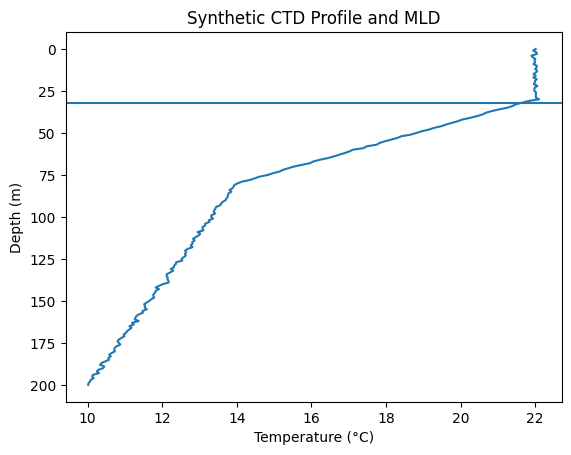

In [3]:
# def mld_T(z, T, zref_max=10, dT_crit=0.2):
#     z = np.asarray(z, float)
#     T = np.asarray(T, float)
#     o = np.argsort(z)
#     z, T = z[o], T[o]
#     mask_ref = z <= zref_max
#     T_ref = T[mask_ref].mean() if mask_ref.any() else T[0]
#     dT = T_ref - T
#     idx = np.where(dT >= dT_crit)[0]
#     return np.nan if idx.size == 0 else z[idx[0]]

def mld_T(z, T, zref_max=10, dT_crit=0.2, dz=1.0):
    z = np.asarray(z, float)
    T = np.asarray(T, float)
    o = np.argsort(z)
    z, T = z[o], T[o]

    z_min, z_max = z.min(), z.max()
    z_reg = np.arange(z_min, z_max + dz, dz)
    T_reg = np.interp(z_reg, z, T)

    mask_ref = z_reg <= zref_max
    T_ref = T_reg[mask_ref].mean() if mask_ref.any() else T_reg[0]
    dT = T_ref - T_reg
    idx = np.where(dT >= dT_crit)[0]

    return (np.nan if idx.size == 0 else z_reg[idx[0]])

mld = mld_T(z, T, dz=1.0)
print("MLD =", mld)

plt.figure()
plt.plot(T, z)
plt.axhline(mld)
plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title("Synthetic CTD Profile and MLD")
plt.show()


MLD (m): 32.0


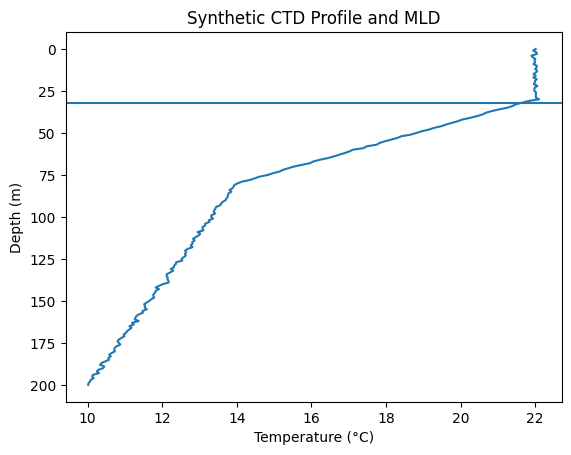

In [4]:
import numpy.ma as ma

# def mld_T_only(T, p, dT_crit=0.5):
#     T = np.asanyarray(T)
#     p = np.asanyarray(p)
#     # surface index (minimum p)
#     p_min, idx = p.min(), p.argmin()
#     T0 = T[idx]
#     # temperature criterion
#     Tdiff = T0 - dT_crit
#     idx_mld = T > Tdiff
#     MLD = ma.masked_all_like(p)
#     MLD[idx_mld] = p[idx_mld]
#     return MLD.max(axis=0), idx_mld

def mld_T_only(T, p, dT_crit=0.5, dp=1.0):
    T = np.asanyarray(T, float)
    p = np.asanyarray(p, float)

    p_min, p_max = p.min(), p.max()
    p_reg = np.arange(p_min, p_max + dp, dp)
    T_reg = np.interp(p_reg, p, T)

    idx_surf = np.argmin(p_reg)
    T0 = T_reg[idx_surf]
    Tdiff = T0 - dT_crit

    idx_mld = T_reg > Tdiff
    MLD = ma.masked_all_like(p_reg)
    MLD[idx_mld] = p_reg[idx_mld]

    return MLD.max(axis=0), idx_mld

MLD_z, idx_mld = mld_T_only(T, z, dT_crit=0.5, dp=1.0)
print("MLD (m):", MLD_z)

plt.figure()
plt.plot(T, z)
plt.axhline(MLD_z)
plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title("Synthetic CTD Profile and MLD")
plt.show()
